# Praxis

In [1]:
import time
import numpy as np
import pandas as pd
import ringity as rng
import networkx as nx
import scipy.stats as ss
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.spatial.distance import pdist, squareform
from ringity.classes.network_model import NetworkBuilder

## Distribution

In [2]:
N = 2**14
beta = 0.523

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 1 - 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)

In [3]:
assert np.isclose(delay, beta)

Given a wrapped exponential distribution with rate parameter $\lambda$, i.e. $\Theta\sim \mathit{WrapExp}(\lambda)$ the pdf can be expressed as
$$f_{\Theta}(t) = \frac{\lambda e^{-\lambda t}}{1-e^{-2\pi\lambda}} \; .$$

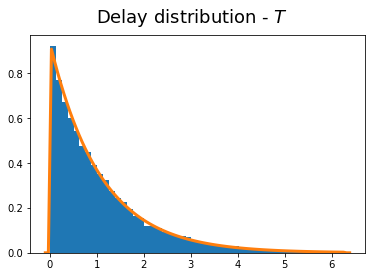

In [4]:
x = np.linspace(-0.1,2*np.pi+0.1,100)

plt.hist(network_builder.positions, density=True, bins=50);
plt.plot(x, rng.pdf_delay(x, rate, 'rate') , linewidth=3)

plt.suptitle("Delay distribution - $T$", fontsize=18);

In [5]:
mu1 = np.mean(network_builder._positions)
mu2 = quad(lambda x : x*rng.pdf_delay(x, rate, 'rate'), 0, 2*np.pi)[0]

print(mu1)
print(mu2)

1.060866553071504
1.056757304047466


In [6]:
rv = ss.truncexpon(b = 2*np.pi*rate, scale = 1/rate)
rv.mean()

1.0567573040474658

In [7]:
ss.ks_1samp(network_builder._positions, rv.cdf)

KstestResult(statistic=0.005849190884225863, pvalue=0.6271770410864851)

## Distances and Similarity

In [20]:
N = 2**13
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')

The circular distance is defined as $D = \min {\left\{ |X-Y|, 2\pi-|X-Y|\right\}}$. The corresponding pdf can be calculated via $f_{D}(t) = f_{|X-Y|}(t) + f_{|X-Y|}(2\pi-t)$ where $f_{|X-Y|}(t) = 2 \cdot f_{\Theta}(t) * f_{\Theta}(-t)$. This boils down to

$$f_{D}(t) = \frac {\lambda}{\sinh(\pi\lambda)}\cdot \cosh(\lambda \cdot (\pi-t)) \; .$$

The corresponding conditional density distribution is defined as $D_{\vartheta} = \min {\left\{ |X-\vartheta|, 2\pi-|X-\vartheta| \right\}}$ and can be calculated via $f_{D_{\vartheta}}(t) = f_{|X-\vartheta|}(t) + f_{|X-\vartheta|}(2\pi-t)$ where $f_{|X-\vartheta|}(t) = f_{\Theta}(\vartheta+t) + f_{\Theta}(\vartheta-t)$. This boils down to 

$$f_{D_{\vartheta}}(t) = \frac{\lambda}{1 - e^{-2\pi\lambda}}
\begin{cases}
2 e^{-\lambda\vartheta} \cosh(\lambda t) & \text{, for } t \leq \theta & \text{and } t \leq 2\pi - \vartheta \\
e^{-\lambda(\vartheta+t)} & \text{, for } t \geq \vartheta & \text{and } t \leq 2\pi - \vartheta\\
e^{-\lambda(\vartheta-t)} & \text{, for } t \leq \vartheta & \text{and } t \geq 2\pi - \vartheta\\
0 &  \text{, for } t \geq \vartheta & \text{and } t \geq 2\pi - \vartheta \; .
\end{cases}
$$

In [243]:
@np.vectorize
def tmp(t, theta, rate):
    if (t < 0) or (t > 2*np.pi):
        return 0.
    support = np.where(0 < t, 1, 0.)
    norm = rate / (1 - np.exp(-2*np.pi*rate))
    
    if 0 <= t <= min(theta, 2*np.pi - theta):
        term = 2 * np.exp(-rate*theta) * np.cosh(rate*t)
    elif theta <= np.pi:
        term = np.exp(-rate*(theta+t))
    else:
        if 2*np.pi - theta <= t <= theta:
            term = np.exp(-rate*(theta-t))
        else:
            term = 0
    return support * norm * term


@np.vectorize
def tmp(t, theta, rate):
    if (t < 0) or (t > 2*np.pi):
        return 0.
    support = np.where(0 < t, 1, 0.)
    norm = rate / (1 - np.exp(-2*np.pi*rate))
    
    if   (t <= theta) and (t <= 2*np.pi - theta):
        term = 2 * np.exp(-rate*theta) * np.cosh(rate*t)
    elif (t >= theta) and (t <= 2*np.pi - theta):
        term = np.exp(-rate*(theta+t))
    elif (t <= theta) and (t >= 2*np.pi - theta):
        term = np.exp(-rate*(theta-t))
    else:
        term = 0
    return support * norm * term

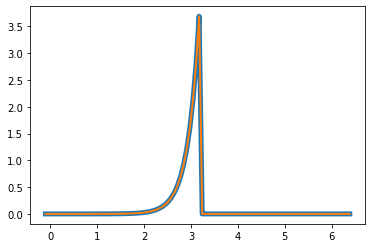

In [244]:
x = np.linspace(-0.1, 2*np.pi+0.1, 100)
theta = 3.2057067893773397

fig, ax = plt.subplots()

ax.plot(x, rng.pdf_conditional_absolute_distance(x, theta=theta, parameter=rate, parameter_type='rate'), 
        linewidth=5)
#ax.plot(x, rng.pdf_delay(x-theta, parameter=rate, parameter_type='rate') +
#           rng.pdf_delay(x+theta, parameter=rate, parameter_type='rate'), linewidth=3)
ax.plot(x, tmp(x, theta, rate) , linewidth=2)

In [245]:
for theta in np.linspace(0, 2*np.pi):
    if not np.allclose(rng.pdf_conditional_absolute_distance(x, theta=theta, parameter=rate, parameter_type='rate'),
                tmp(x, theta, rate), atol=1e-05):
        print(theta)
        break

In [246]:
a = rng.pdf_conditional_absolute_distance(x, theta=3.2057067893773397, parameter=rate, parameter_type='rate')
b = tmp(x, 3.2057067893773397, rate)

c = a-b
b[abs(c) > 0.0000001]

array([], dtype=float64)

In [247]:
x[abs(c) > 0.0000001]

array([], dtype=float64)

In [248]:
rng.pdf_conditional_absolute_distance(3.17408573, theta=3.2057067893773397, parameter=rate, parameter_type='rate')

3.686077837889709

In [241]:
tmp(3.17408573, 3.2057067893773397, rate)

array(3.68607784)

In [242]:
np.allclose()

TypeError: _allclose_dispatcher() missing 2 required positional arguments: 'a' and 'b'

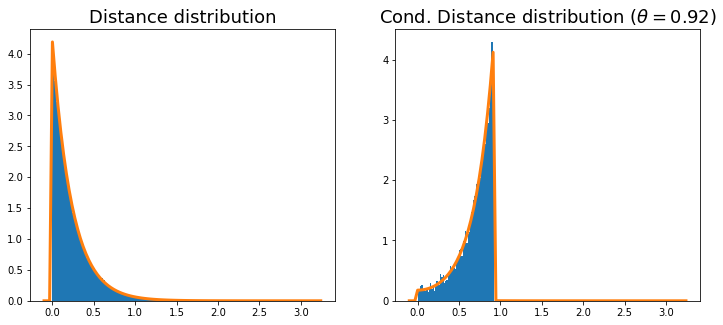

In [24]:
x = np.linspace(-0.1, np.pi+0.1, 100)

i = 200
theta = network_builder._positions[i]

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.hist(network_builder._distances, density=True, bins=100);
ax1.plot(x, rng.pdf_circular_distance(x, rate, 'rate') , linewidth=3)
ax1.set_title("Distance distribution", fontsize=18);

ax2.hist(network_builder.distances[i,:], density=True, bins=100);
ax2.plot(x, rng.pdf_conditional_circular_distance(x, theta=theta, parameter=rate, parameter_type='rate') , linewidth=3)
ax2.set_title(rf"Cond. Distance distribution ($\theta = {theta:.2f}$)", fontsize=18);

In [10]:
mu1 = np.mean(network_builder._distances)
mu2 = quad(lambda x : x*rng.pdf_circular_distance(x, rate, 'rate'), 0, 2*np.pi)[0]

print(mu1)
print(mu2)

0.34361943278981644
0.343580655285218


In [11]:
disc_part = 2*(network_builder._similarities!=0).sum() / (N*(N-1))

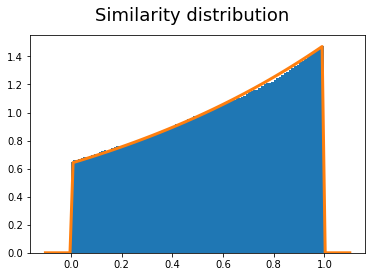

In [12]:
x = np.linspace(-0.1, 1.1, 100)

plt.hist(network_builder._similarities[network_builder._similarities!=0], density=True, bins=100);
plt.plot(x, rng.pdf_similarity(x, parameter = rate, a = alpha, parameter_type = 'rate')/disc_part , linewidth=3)

plt.suptitle("Similarity distribution", fontsize=18);

In [13]:
mu1 = np.mean(network_builder._similarities)
mu2 = quad(lambda x : x*rng.pdf_similarity(x, parameter = rate, a=alpha, parameter_type='rate'), 
           0, 2*np.pi)[0]

print(mu1)
print(mu2)

0.32224083237871715
0.3241550454442353


In [14]:
rng.classes.network_model.mean_similarity(a=alpha, rate = rate)

0.32415504526088246

In [15]:
def mean_similarity(rate, a):
    """Calculate expected mean similarity (equivalently maximal expected density). 
    
    This function assumies a (wrapped) exponential function and a cosine similarity 
    of box functions.
    """
    palph = a*2
    plamb = np.pi * rate
    
    # Alternatively:
    numerator = 2*(np.sinh(plamb*(1-a)) * np.sinh(plamb*a))
#    numerator = (np.cosh(plamb) - np.cosh(plamb*(1 - palph)))
    denominator = (palph*plamb * np.sinh(plamb))
    
    return 1 - numerator / denominator 

In [16]:
mean_similarity(a=alpha, rate = rate)

0.3241550452608818

## Probability

In [51]:
N = 2**9
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)

max_rho = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)
rho = np.random.uniform(0, max_rho)

K = rng.classes.network_model.density_to_interaction_strength(rho, a=alpha, rate=rate)
density = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)*K

network_builder = NetworkBuilder()
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
network_builder.calculate_probabilities(intercept=0, slope = K)
network_builder.instantiate_network()

In [52]:
assert np.isclose(rho, density)

In [53]:
disc_part = 2*(network_builder._probabilities!=0).sum() / (N*(N-1))

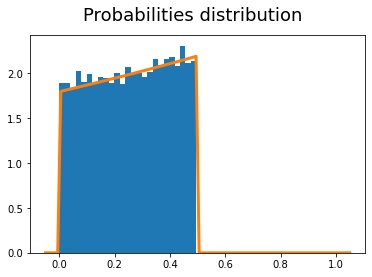

In [54]:
x = np.linspace(-0.05, 1.05, 100)

plt.hist(network_builder._probabilities[network_builder._probabilities != 0], density=True, bins=25);
plt.plot(x, rng.pdf_probability(x, 
                                rho = rho,
                                parameter = rate, 
                                a = alpha, 
                                parameter_type = 'rate')/disc_part , linewidth=3)

plt.suptitle("Probabilities distribution", fontsize=18);

In [55]:
mu1 = np.mean(network_builder._probabilities)
mu2 = quad(lambda x : x*rng.pdf_probability(x, parameter = rate, a=alpha, rho=rho, parameter_type='rate'), 
           0, 2*np.pi)[0]

print(mu1)
print(mu2)

0.04683326319551728
0.04644061639041624


# Conditional distributions

## Conditional Distances and Similarity

In [56]:
# Pipeline

N = 2**13
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')

theta = network_builder.positions[0]

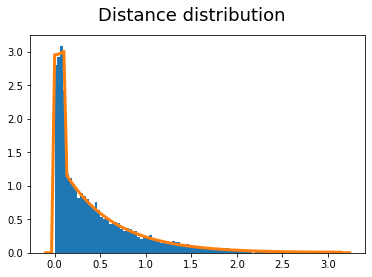

In [63]:
x = np.linspace(-0.1, np.pi+0.1, 100)

plt.hist(network_builder.distances[0], density=True, bins=100);
plt.plot(x, rng.pdf_conditional_circular_distance(x, 
                                                  theta=theta, 
                                                  parameter=rate, 
                                                  parameter_type='rate') , linewidth=3)

plt.suptitle("Distance distribution", fontsize=18);

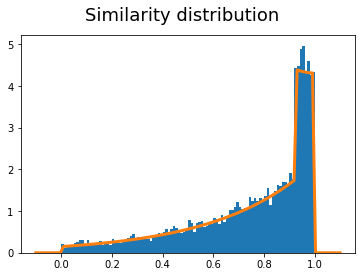

In [72]:
x = np.linspace(-0.1, 1.1, 100)

similarities = network_builder.similarities[0]
disc_part = 2*(similarities!=0).sum() / (N*(N-1))

plt.hist(similarities[similarities!=0], density=True, bins=100);
plt.plot(x, rng.pdf_conditional_similarity(x, 
                                           theta = theta,
                                           parameter = rate, 
                                           a = alpha, 
                                           parameter_type = 'rate') , linewidth=3)

plt.suptitle("Similarity distribution", fontsize=18);

## Conditional probabilities

In [88]:
N = 2**9
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)

max_rho = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)
rho = np.random.uniform(0, max_rho)

K = rng.classes.network_model.density_to_interaction_strength(rho, a=alpha, rate=rate)
density = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)*K

network_builder = NetworkBuilder()
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
network_builder.calculate_probabilities(intercept=0, slope = K)
network_builder.instantiate_network()

theta = network_builder.positions[0]

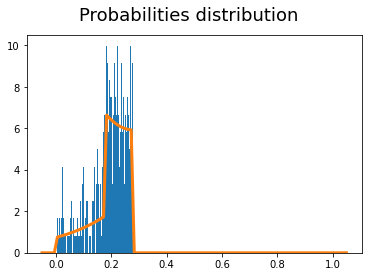

In [89]:
x = np.linspace(-0.05, 1.05, 100)

probabilities = network_builder.probabilities[0]
disc_part = 2*(probabilities!=0).sum() / (N*(N-1))

plt.hist(probabilities[probabilities!=0], density=True, bins=100);

plt.plot(x, rng.pdf_conditional_probability(x, 
                                            theta = theta,
                                            rho = rho,
                                            parameter = rate, 
                                            a = alpha, 
                                            parameter_type = 'rate') , linewidth=3)

plt.suptitle("Probabilities distribution", fontsize=18);